## **MONISHA PATRO**

---

## **Dataset Overview**

- Name: PaySim Dataset
- Description: A synthetic dataset simulating mobile money transactions.
- Rows: ~6 million
- Features:
  - step, type, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest,
    oldbalanceDest, newbalanceDest, isFraud, isFlaggedFraud
- Use: Fraud detection tasks, anomaly detection, large-scale analytics.

We will do unsupervised ML (IsolationForest, LOF, Autoencoder) on a *sample*
for cost/time reasons, then visualize results. We'll also do "real-time" row-by-row detection.


---

## **Environment Setup & Version Checks**

In [1]:
import sys
print("Python version:", sys.version)

!pip show scikit-learn | grep Version
!pip show pandas | grep Version
!pip show numpy | grep Version
!pip show matplotlib | grep Version
!pip show seaborn | grep Version
!pip show tensorflow | grep Version
!pip show pyspark | grep Version

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

import sklearn
import tensorflow as tf
import pyspark

print("\nscikit-learn version:", sklearn.__version__)
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)
print("tensorflow version:", tf.__version__)
print("pyspark version:", pyspark.__version__)

Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
Version: 1.6.1
 Version 3.1, 31 March 2009
Version: 2.2.2
Version: 1.26.4
Version 3.1, 31 March 2009
                       Version 3, 29 June 2007
  5. Conveying Modified Source Versions.
  14. Revised Versions of this License.
Version: 3.10.0
Version: 0.13.2
Version: 2.18.0
Version: 3.5.4

scikit-learn version: 1.6.1
pandas version: 2.2.2
numpy version: 1.26.4
matplotlib version: 3.10.0
seaborn version: 0.13.2
tensorflow version: 2.18.0
pyspark version: 3.5.4


---

### **Mount Google Drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
csv_path =  "/content/drive/My Drive/Fraud-Detection-in-Transactions/Dataset/Transactions.csv"

In [34]:
iso_forest_path = "/content/drive/My Drive/Fraud-Detection-in-Transactions/Models/iso_forest.pkl"
lof_path = "/content/drive/My Drive/Fraud-Detection-in-Transactions/Models/lof.pkl"
autoencoder_path = "/content/drive/My Drive/Fraud-Detection-in-Transactions/Models/autoencoder.h5"

---

**Load PaySim dataset**

In [6]:
df = pd.read_csv(csv_path)
print("Dataset loaded. Shape:", df.shape)
df.head(10)

Dataset loaded. Shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


---

## **Exploratory Data Analysis**

In [7]:
print("\n--- Data Info ---")
df.info()


--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [8]:
print("\n--- Describe ---")
display(df.describe())


--- Describe ---


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [9]:
print("\n--- Null Check ---")
print(df.isnull().sum())


--- Null Check ---
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [10]:
print("\n--- Fraud Distribution ---")
print(df['isFraud'].value_counts())


--- Fraud Distribution ---
isFraud
0    6354407
1       8213
Name: count, dtype: int64


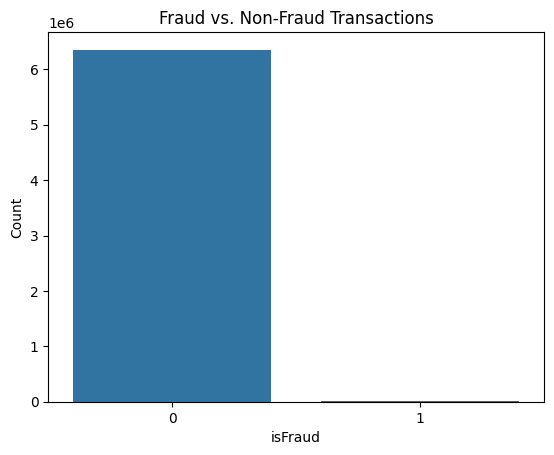

In [11]:
fraud_counts = df['isFraud'].value_counts()
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.title("Fraud vs. Non-Fraud Transactions")
plt.xlabel("isFraud")
plt.ylabel("Count")
plt.show()

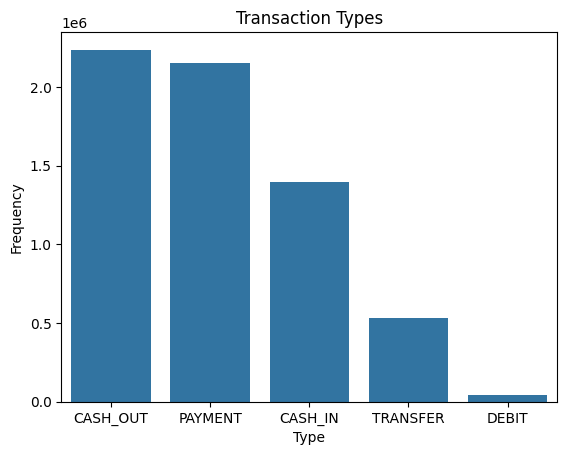

In [12]:
tx_counts = df['type'].value_counts()
sns.barplot(x=tx_counts.index, y=tx_counts.values)
plt.title("Transaction Types")
plt.xlabel("Type")
plt.ylabel("Frequency")
plt.show()

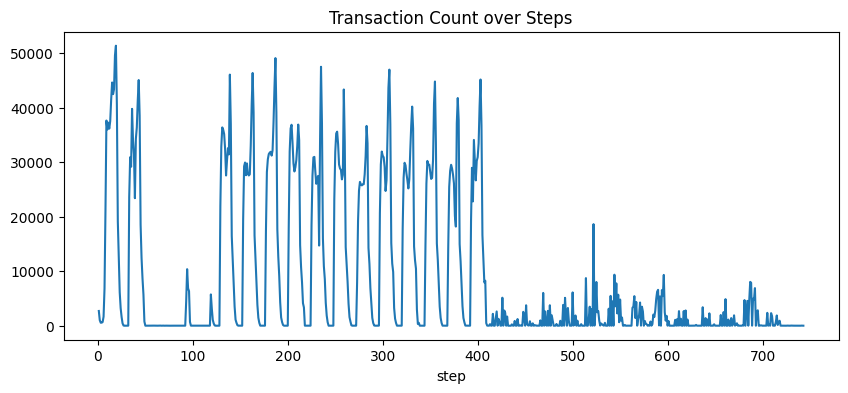

In [13]:
df.groupby('step')['amount'].count().plot(kind='line', figsize=(10,4), title='Transaction Count over Steps')
plt.show()

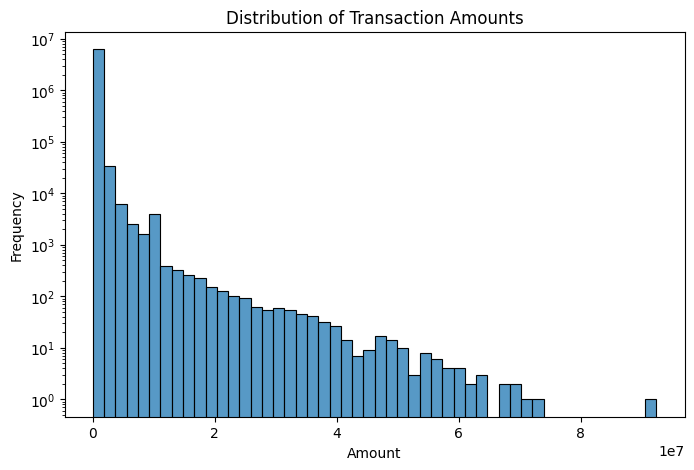

In [14]:
# Distribution of Amount
plt.figure(figsize=(8,5))
sns.histplot(df['amount'], bins=50, kde=False)
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.yscale('log')
plt.show()

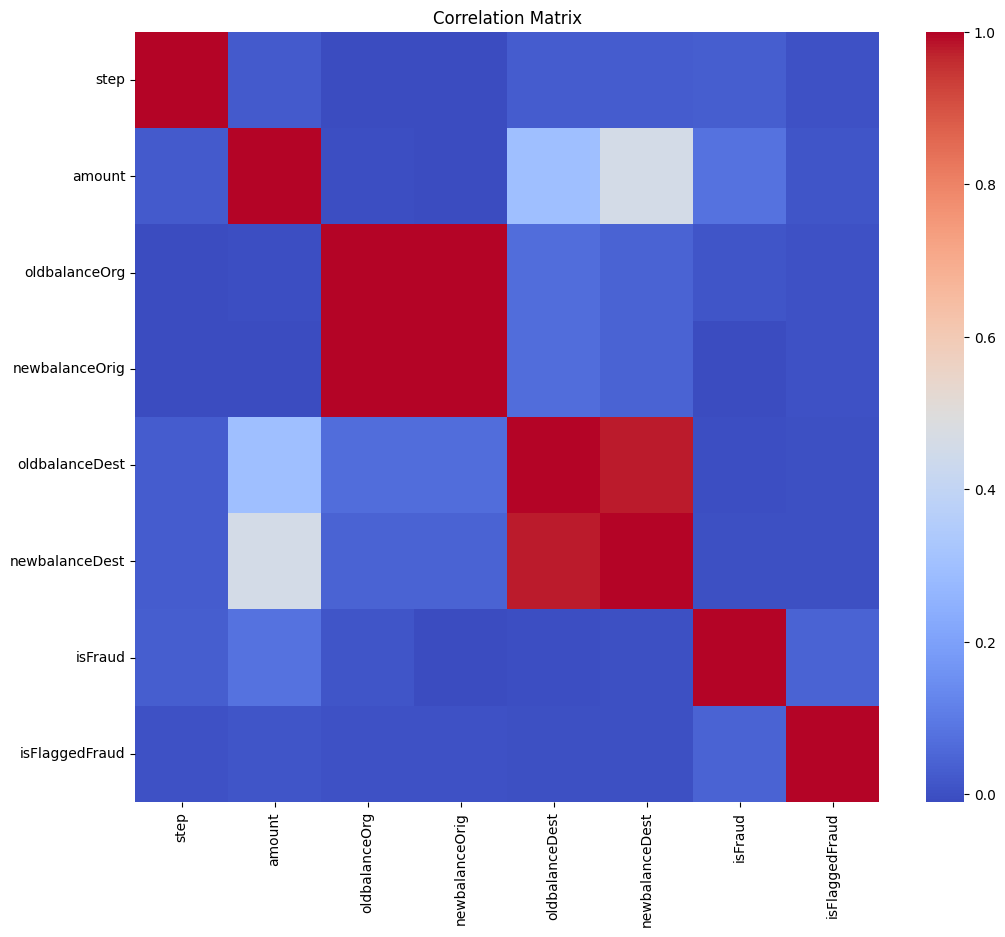

In [15]:
# Correlation Heatmap
plt.figure(figsize=(12,10))
corr_matrix = df.corr(numeric_only=True)  # if using pandas 2.x
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Correlation Matrix")
plt.show()

---

## **Feature Engineering & Preprocessing**

In [16]:
# Drop columns that we don't need
df.drop(['nameOrig','nameDest','isFlaggedFraud'], axis=1, inplace=True)

In [17]:
# Convert 'type' to dummies
df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [18]:
# Create delta balances
df['delta_balanceOrig'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['delta_balanceDest'] = df['newbalanceDest'] - df['oldbalanceDest']

In [19]:
# Ratio: amount / oldbalanceOrg
def ratio_func(row):
    if row['oldbalanceOrg'] > 0:
        return row['amount'] / row['oldbalanceOrg']
    else:
        return 0

In [20]:
df['amount_div_oldbalanceOrg'] = df.apply(ratio_func, axis=1)

print("\n--- Data Sample after Feature Engineering ---")
df.head(10)


--- Data Sample after Feature Engineering ---


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,delta_balanceOrig,delta_balanceDest,amount_div_oldbalanceOrg
0,1,9839.64,170136.00,160296.36,0.0,0.00,0,False,False,True,False,-9839.64,0.00,0.057834
1,1,1864.28,21249.00,19384.72,0.0,0.00,0,False,False,True,False,-1864.28,0.00,0.087735
2,1,181.00,181.00,0.00,0.0,0.00,1,False,False,False,True,-181.00,0.00,1.000000
3,1,181.00,181.00,0.00,21182.0,0.00,1,True,False,False,False,-181.00,-21182.00,1.000000
4,1,11668.14,41554.00,29885.86,0.0,0.00,0,False,False,True,False,-11668.14,0.00,0.280795
5,1,7817.71,53860.00,46042.29,0.0,0.00,0,False,False,True,False,-7817.71,0.00,0.145149
6,1,7107.77,183195.00,176087.23,0.0,0.00,0,False,False,True,False,-7107.77,0.00,0.038799
7,1,7861.64,176087.23,168225.59,0.0,0.00,0,False,False,True,False,-7861.64,0.00,0.044646
8,1,4024.36,2671.00,0.00,0.0,0.00,0,False,False,True,False,-2671.00,0.00,1.506687
9,1,5337.77,41720.00,36382.23,41898.0,40348.79,0,False,True,False,False,-5337.77,-1549.21,0.127943


---

## **Train/Test Split & Subsampling**

In [21]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

print("Original shape X:", X.shape, "y:", y.shape)
print("Number of Fraud transactions:", sum(y))

Original shape X: (6362620, 13) y: (6362620,)
Number of Fraud transactions: 8213


In [23]:
from sklearn.model_selection import train_test_split

max_rows = 500_000
if len(X) > max_rows:
    df_sample = df.sample(n=max_rows, random_state=42)
    X = df_sample.drop('isFraud', axis=1)
    y = df_sample['isFraud']
    print("\nSampled shape X:", X.shape, "y:", y.shape)
    print("Number of Fraud in sample:", sum(y))

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (350000, 13) Test shape: (150000, 13)


---

## **Scaling**

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaling done.")

Scaling done.


---

## **Isolation Forest**

In [35]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

iso_forest = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    contamination='auto',
    random_state=42
)
iso_forest.fit(X_train_scaled)

y_pred_iso = iso_forest.predict(X_test_scaled)
y_pred_iso_binary = [1 if x == -1 else 0 for x in y_pred_iso]

print("\n=== Isolation Forest ===")
print(classification_report(y_test, y_pred_iso_binary))
print(confusion_matrix(y_test, y_pred_iso_binary))

joblib.dump(iso_forest, iso_forest_path)
print(f"Isolation Forest saved to: {iso_forest_path}")


=== Isolation Forest ===
              precision    recall  f1-score   support

           0       1.00      0.92      0.96    149806
           1       0.01      0.61      0.02       194

    accuracy                           0.92    150000
   macro avg       0.50      0.76      0.49    150000
weighted avg       1.00      0.92      0.96    150000

[[137932  11874]
 [    76    118]]
Isolation Forest saved to: /content/drive/My Drive/Fraud-Detection-in-Transactions/Models/iso_forest.pkl


---

## **Local Outlier Factor (LOF)**

In [39]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination='auto',
    novelty=True
)
lof.fit(X_train_scaled)

y_pred_lof = lof.predict(X_test_scaled)
y_pred_lof_binary = [1 if x == -1 else 0 for x in y_pred_lof]

print("\n=== Local Outlier Factor ===")
print(classification_report(y_test, y_pred_lof_binary))
print(confusion_matrix(y_test, y_pred_lof_binary))

joblib.dump(lof, lof_path)
print(f"LOF model saved to: {lof_path}")


=== Local Outlier Factor ===
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    149806
           1       0.00      0.03      0.00       194

    accuracy                           0.96    150000
   macro avg       0.50      0.50      0.49    150000
weighted avg       1.00      0.96      0.98    150000

[[143849   5957]
 [   188      6]]
LOF model saved to: /content/drive/My Drive/Fraud-Detection-in-Transactions/Models/lof.pkl


---

## **Autoencoder (Deep Learning)**

In [41]:
# We'll train the autoencoder on normal only (isFraud=0) from the training set

X_train_normal = X_train[y_train == 0]

# Sampling the normal subset further
max_norm = 200_000
if len(X_train_normal) > max_norm:
    X_train_normal = X_train_normal.sample(n=max_norm, random_state=42)

# Scale
X_train_normal_scaled = scaler.fit_transform(X_train_normal)

input_dim = X_train_normal_scaled.shape[1]


# Import layers module
from tensorflow.keras import layers

auto_model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(input_dim,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(input_dim, activation='linear')
])

auto_model.compile(optimizer='adam', loss='mse')
auto_model.summary()

history = auto_model.fit(
    X_train_normal_scaled, X_train_normal_scaled,
    epochs=5,
    batch_size=256,
    validation_split=0.2,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 13)                  │             845 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,933 (23.18 KB)

 Trainable params: 5,933 (23.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.4065 - val_loss: 0.0049
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0340 - val_loss: 0.0021
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0288 - val_loss: 0.0033
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0277 - val_loss: 0.0034
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1613 - val_loss: 0.0028


**Autoencoder Evaluation**

In [42]:
import numpy as np

recon_train = auto_model.predict(X_train_normal_scaled)
mse_train = np.mean(np.square(X_train_normal_scaled - recon_train), axis=1)
threshold = np.percentile(mse_train, 99)
print("Autoencoder threshold:", threshold)

X_test_scaled_auto = scaler.transform(X_test)
recon_test = auto_model.predict(X_test_scaled_auto)
mse_test = np.mean(np.square(X_test_scaled_auto - recon_test), axis=1)

y_pred_auto = [1 if e > threshold else 0 for e in mse_test]

print("\n=== Autoencoder ===")
print(classification_report(y_test, y_pred_auto))
print(confusion_matrix(y_test, y_pred_auto))

auto_model.save(autoencoder_path)
print(f"Autoencoder saved to: {autoencoder_path}")

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step
Autoencoder threshold: 0.020649926666203123
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step



=== Autoencoder ===
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    149806
           1       0.07      0.54      0.12       194

    accuracy                           0.99    150000
   macro avg       0.53      0.76      0.56    150000
weighted avg       1.00      0.99      0.99    150000

[[148328   1478]
 [    90    104]]
Autoencoder saved to: /content/drive/My Drive/Fraud-Detection-in-Transactions/Models/autoencoder.h5


---

## **Model Comparison & Real-Time Simulation**

**Compare Models**

In [44]:
models = ['Isolation Forest','LOF','Autoencoder']
precision_fraud = [0.01, 0.00, 0.07]
recall_fraud = [0.61, 0.03, 0.54]
f1_fraud = [0.02, 0.00, 0.12]

comparison_df = pd.DataFrame({
    'Model': models,
    'Precision (Fraud)': precision_fraud,
    'Recall (Fraud)': recall_fraud,
    'F1-score (Fraud)': f1_fraud
})
print("\n--- Model Comparison ---")
display(comparison_df)


--- Model Comparison ---


,Model,Precision (Fraud),Recall (Fraud),F1-score (Fraud)
0,Isolation Forest,0.01,0.61,0.02
1,LOF,0.00,0.03,0.00
2,Autoencoder,0.07,0.54,0.12


**Simple Real-Time Simulation (Isolation Forest)**

In [45]:
print("\n--- Real-Time Simulation with Isolation Forest ---")
subset_size = 1000
X_test_subset = X_test.iloc[:subset_size].copy()
y_test_subset = y_test.iloc[:subset_size].copy()

for idx, row in X_test_subset.iterrows():
    row_scaled = scaler.transform([row])  # shape=(1, n_features)
    pred = iso_forest.predict(row_scaled)[0]  # -1 or 1
    pred_label = 1 if pred == -1 else 0

    actual_label = y_test_subset.loc[idx]
    if pred_label == 1:
        print(f"[ALERT] Transaction {idx} flagged FRAUD. Actual={actual_label}")

    time.sleep(0.003)  # mimic streaming


--- Real-Time Simulation with Isolation Forest ---


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 1218989 flagged FRAUD. Actual=0
[ALERT] Transaction 1721741 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 6086136 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 1407364 flagged FRAUD. Actual=0
[ALERT] Transaction 4245888 flagged FRAUD. Actual=0
[ALERT] Transaction 5790626 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 5214831 flagged FRAUD. Actual=0
[ALERT] Transaction 5694887 flagged FRAUD. Actual=0
[ALERT] Transaction 5178806 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 5683017 flagged FRAUD. Actual=0
[ALERT] Transaction 892936 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 32195 flagged FRAUD. Actual=0
[ALERT] Transaction 6348418 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 4278966 flagged FRAUD. Actual=0
[ALERT] Transaction 4265765 flagged FRAUD. Actual=0
[ALERT] Transaction 1587553 flagged FRAUD. Actual=0
[ALERT] Transaction 5378936 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 871250 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 4092104 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 2771941 flagged FRAUD. Actual=0
[ALERT] Transaction 4427601 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 6105301 flagged FRAUD. Actual=0
[ALERT] Transaction 4161144 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 4903434 flagged FRAUD. Actual=0
[ALERT] Transaction 4077633 flagged FRAUD. Actual=0
[ALERT] Transaction 4019113 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 5172725 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 6066593 flagged FRAUD. Actual=0
[ALERT] Transaction 753353 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 5747951 flagged FRAUD. Actual=0
[ALERT] Transaction 5223696 flagged FRAUD. Actual=0
[ALERT] Transaction 5947856 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 5221201 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 4877253 flagged FRAUD. Actual=0
[ALERT] Transaction 2469517 flagged FRAUD. Actual=0
[ALERT] Transaction 3053624 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 6175402 flagged FRAUD. Actual=0
[ALERT] Transaction 3330747 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 1977150 flagged FRAUD. Actual=0
[ALERT] Transaction 2491273 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 1024367 flagged FRAUD. Actual=0
[ALERT] Transaction 425021 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 6259522 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 13097 flagged FRAUD. Actual=0
[ALERT] Transaction 4836745 flagged FRAUD. Actual=0
[ALERT] Transaction 4763260 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 4825701 flagged FRAUD. Actual=0
[ALERT] Transaction 5629229 flagged FRAUD. Actual=0
[ALERT] Transaction 2868545 flagged FRAUD. Actual=0
[ALERT] Transaction 6356977 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 720016 flagged FRAUD. Actual=0
[ALERT] Transaction 1789441 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 4017718 flagged FRAUD. Actual=0
[ALERT] Transaction 4575269 flagged FRAUD. Actual=0
[ALERT] Transaction 4231711 flagged FRAUD. Actual=0
[ALERT] Transaction 5901209 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 6115896 flagged FRAUD. Actual=0
[ALERT] Transaction 2546139 flagged FRAUD. Actual=0
[ALERT] Transaction 4053835 flagged FRAUD. Actual=0
[ALERT] Transaction 42426 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 2491833 flagged FRAUD. Actual=0
[ALERT] Transaction 5060666 flagged FRAUD. Actual=0
[ALERT] Transaction 3285981 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 5402550 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 325651 flagged FRAUD. Actual=0
[ALERT] Transaction 2697961 flagged FRAUD. Actual=0
[ALERT] Transaction 5038198 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 6318604 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 2425830 flagged FRAUD. Actual=0
[ALERT] Transaction 1612037 flagged FRAUD. Actual=0
[ALERT] Transaction 81720 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 4747850 flagged FRAUD. Actual=0
[ALERT] Transaction 533146 flagged FRAUD. Actual=0
[ALERT] Transaction 6241872 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 6216368 flagged FRAUD. Actual=0
[ALERT] Transaction 5390540 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[ALERT] Transaction 3751346 flagged FRAUD. Actual=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut